In [1]:
!pip install transformers datasets rouge-score torch pandas numpy tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e510d08c8efc92067dae7b0afa0246b9de5ddea216336d9a01ad47a2026ee1d3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [2]:

import numpy as np
import pandas as pd
from rouge_score import rouge_scorer
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch
import time
import matplotlib.pyplot as plt

# Define candidate models
models = [
    "facebook/bart-large-cnn",
    "t5-base",
    "google/pegasus-cnn_dailymail",
    "sshleifer/distilbart-cnn-12-6",
    "facebook/bart-large-xsum"
]

# Define evaluation criteria and their weights
criteria = {
    'rouge1_f1': {'weight': 0.25, 'impact': 'positive'},
    'rouge2_f1': {'weight': 0.25, 'impact': 'positive'},
    'rougeL_f1': {'weight': 0.25, 'impact': 'positive'},
    'inference_time': {'weight': 0.15, 'impact': 'negative'},
    'model_size': {'weight': 0.10, 'impact': 'negative'}
}

def load_test_data(num_samples=50):
    """Load sample data from CNN/DailyMail dataset"""
    from datasets import load_dataset
    dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
    return dataset.select(range(num_samples))

def evaluate_model(model_name, test_data):
    """Evaluate a single model on test data"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    summarizer = pipeline("summarization", model=model_name, device=0 if device == "cuda" else -1)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    results = {
        'rouge1_f1': [],
        'rouge2_f1': [],
        'rougeL_f1': [],
        'inference_time': [],
        'model_size': []
    }

    # Get model size in MB
    model_size = summarizer.model.num_parameters() * 4 / (1024 * 1024)

    for item in tqdm(test_data, desc=f"Evaluating {model_name}"):
        try:
            start_time = time.time()
            summary = summarizer(item['article'][:1024], max_length=130, min_length=30)[0]['summary_text']
            inference_time = time.time() - start_time

            # Calculate ROUGE scores
            scores = scorer.score(item['highlights'], summary)

            results['rouge1_f1'].append(scores['rouge1'].fmeasure)
            results['rouge2_f1'].append(scores['rouge2'].fmeasure)
            results['rougeL_f1'].append(scores['rougeL'].fmeasure)
            results['inference_time'].append(inference_time)
            results['model_size'].append(model_size)
        except Exception as e:
            print(f"Error processing item with {model_name}: {str(e)}")
            continue

    return {k: np.mean(v) for k, v in results.items()}

def apply_topsis(decision_matrix, criteria):
    """Apply TOPSIS method"""
    # Normalize the decision matrix
    normalized = decision_matrix.copy()
    for column in normalized.columns:
        normalized[column] = normalized[column] / np.sqrt((normalized[column]**2).sum())

    # Weight multiplication
    for column in normalized.columns:
        normalized[column] = normalized[column] * criteria[column]['weight']

    # Ideal best and worst solutions
    ideal_best = []
    ideal_worst = []

    for column in normalized.columns:
        if criteria[column]['impact'] == 'positive':
            ideal_best.append(normalized[column].max())
            ideal_worst.append(normalized[column].min())
        else:
            ideal_best.append(normalized[column].min())
            ideal_worst.append(normalized[column].max())

    # Calculate separation measures
    s_best = np.sqrt(((normalized - ideal_best)**2).sum(axis=1))
    s_worst = np.sqrt(((normalized - ideal_worst)**2).sum(axis=1))

    # Calculate relative closeness
    performance_score = s_worst / (s_best + s_worst)

    return performance_score

# Main execution
def main():
    print("Loading test data...")
    test_data = load_test_data(num_samples=20)  # Using 20 samples for demonstration

    print("Evaluating models...")
    results = {}
    for model_name in models:
        try:
            results[model_name] = evaluate_model(model_name, test_data)
            print(f"Completed evaluation of {model_name}")
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue

    # Create decision matrix
    decision_matrix = pd.DataFrame(results).T

    print("Applying TOPSIS...")
    performance_scores = apply_topsis(decision_matrix, criteria)

    # Final rankings
    rankings = pd.DataFrame({
        'Model': decision_matrix.index,
        'TOPSIS Score': performance_scores
    }).sort_values('TOPSIS Score', ascending=False)

    return rankings, decision_matrix

# Save results and create visualizations
def save_results(rankings, decision_matrix):
    # Save rankings to CSV
    rankings.to_csv('model_rankings.csv', index=False)

    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.bar(rankings['Model'], rankings['TOPSIS Score'])
    plt.xticks(rotation=45)
    plt.title('Model Rankings by TOPSIS Score')
    plt.tight_layout()
    plt.savefig('model_rankings.png')

    # Save detailed metrics
    decision_matrix.to_csv('model_metrics.csv')

# Print DataFrame display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Loading test data...
Evaluating models...


Device set to use cpu
Evaluating facebook/bart-large-cnn: 100%|██████████| 20/20 [03:57<00:00, 11.88s/it]


Completed evaluation of facebook/bart-large-cnn


Device set to use cpu
Evaluating t5-base: 100%|██████████| 20/20 [03:10<00:00,  9.51s/it]


Completed evaluation of t5-base


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Evaluating google/pegasus-cnn_dailymail: 100%|██████████| 20/20 [09:34<00:00, 28.74s/it]


Completed evaluation of google/pegasus-cnn_dailymail


Device set to use cpu
Evaluating sshleifer/distilbart-cnn-12-6: 100%|██████████| 20/20 [02:55<00:00,  8.79s/it]


Completed evaluation of sshleifer/distilbart-cnn-12-6


Device set to use cpu
Evaluating facebook/bart-large-xsum: 100%|██████████| 20/20 [03:37<00:00, 10.89s/it]



Completed evaluation of facebook/bart-large-xsum
Applying TOPSIS...

Final Rankings:
                                                       Model  TOPSIS Score
facebook/bart-large-cnn              facebook/bart-large-cnn      0.822284
sshleifer/distilbart-cnn-12-6  sshleifer/distilbart-cnn-12-6      0.784066
t5-base                                              t5-base      0.582535
facebook/bart-large-xsum            facebook/bart-large-xsum      0.469209
google/pegasus-cnn_dailymail    google/pegasus-cnn_dailymail      0.208922
Completed evaluation of facebook/bart-large-xsum
Applying TOPSIS...

Final Rankings:
                                                       Model  TOPSIS Score
facebook/bart-large-cnn              facebook/bart-large-cnn      0.822284
sshleifer/distilbart-cnn-12-6  sshleifer/distilbart-cnn-12-6      0.784066
t5-base                                              t5-base      0.582535
facebook/bart-large-xsum            facebook/bart-large-xsum      0.469209
googl

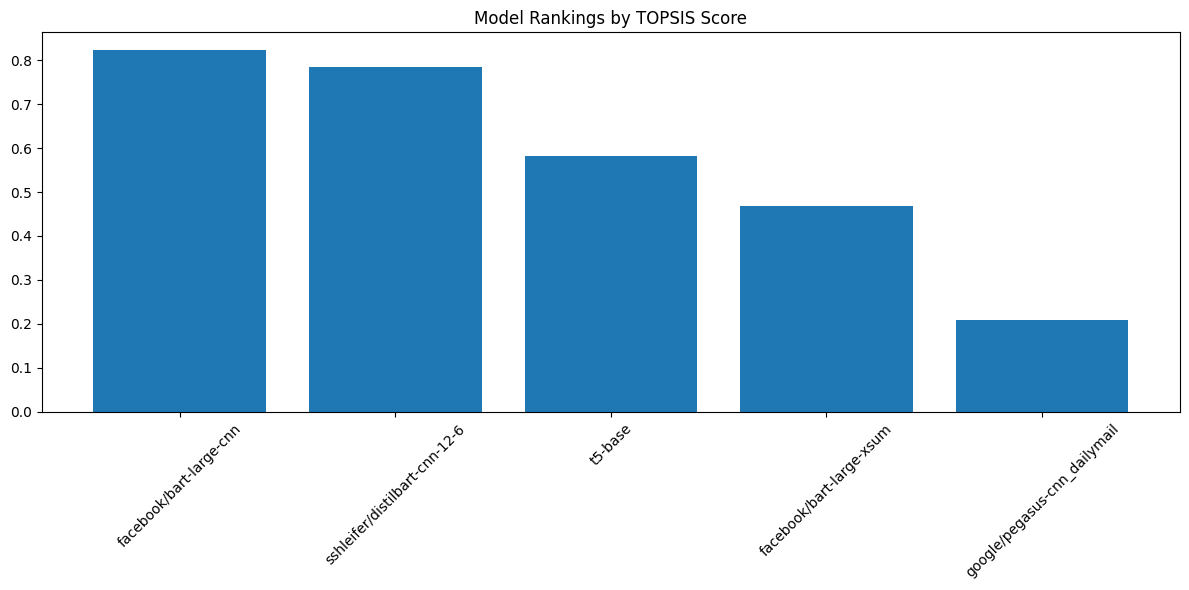

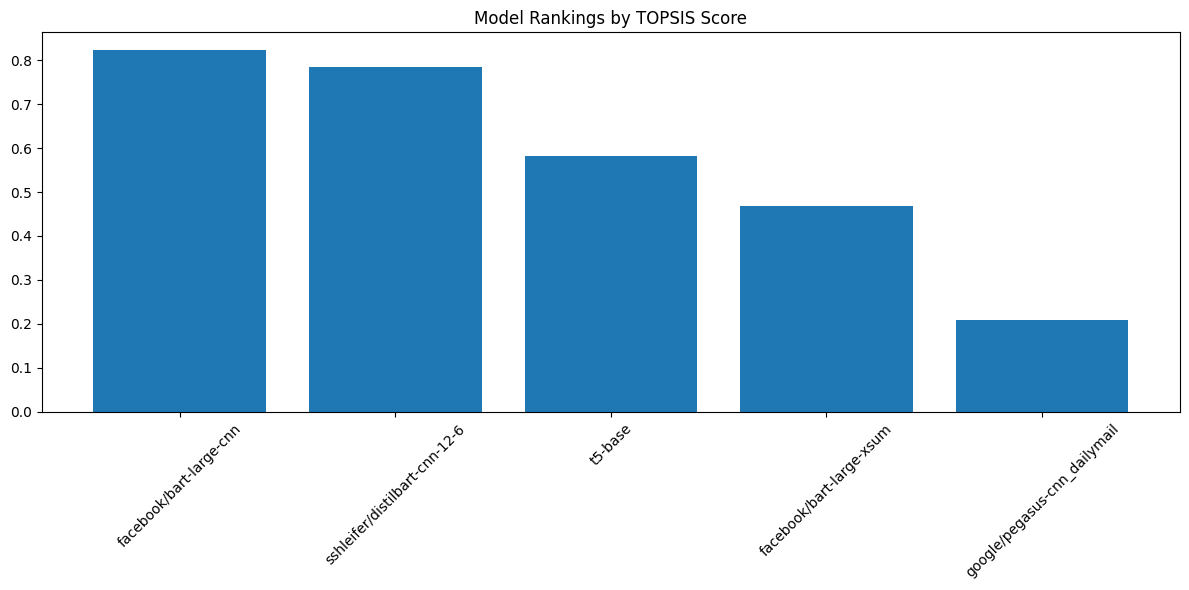

In [4]:
# Run the evaluation
rankings, metrics = main()

# Display results
print("\nFinal Rankings:")
print(rankings)

# Save results
save_results(rankings, metrics)